# Antenna Analysis

## Sweep Version 0
- No matching done
- Sweep between 700 MHz - 1 GHz

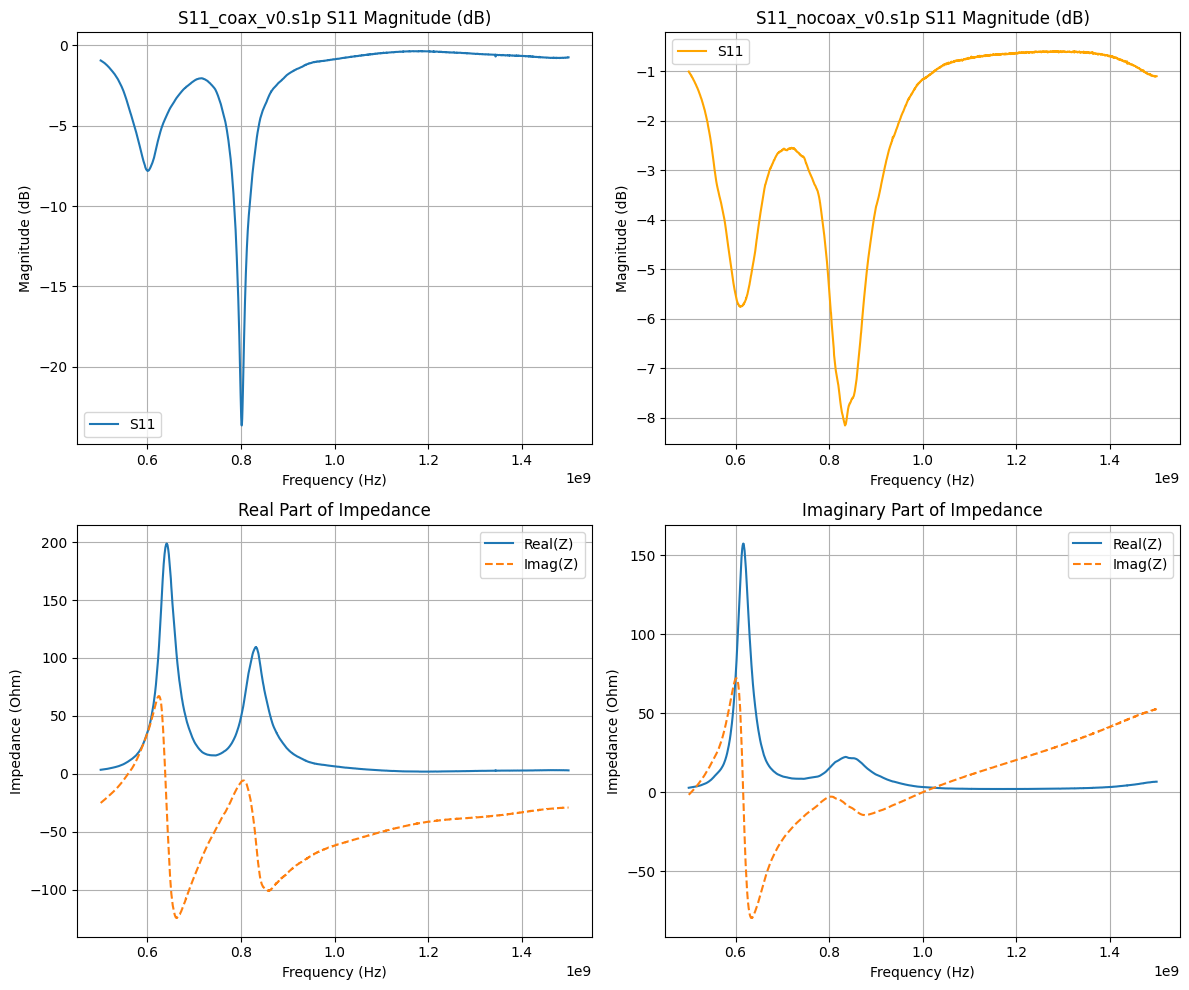

In [1]:
import skrf as rf
import numpy as np
import matplotlib.pyplot as plt
import os

# Replace these with the paths to your S1P files
folder = 'data'
file1 = 'S11_coax_v0.s1p'
filepath1 = os.path.join(folder, file1)
file2 = 'S11_nocoax_v0.s1p'
filepath2 = os.path.join(folder, file2)

# Read the two S1P files
ntw1 = rf.Network(filepath1)
ntw2 = rf.Network(filepath2)

# Extract frequency arrays from each file (assumed to be similar or identical)
freq1 = ntw1.frequency.f
freq2 = ntw2.frequency.f

# Extract the S11 parameter for each network (S1P files only contain one port)
s11_1 = ntw1.s[:, 0, 0]
s11_2 = ntw2.s[:, 0, 0]

# Convert S11 magnitude to dB
s11_1_db = 20 * np.log10(np.abs(s11_1))
s11_2_db = 20 * np.log10(np.abs(s11_2))

# Compute the impedance for each network using the built-in z attribute
z1 = ntw1.z[:, 0, 0]
z2 = ntw2.z[:, 0, 0]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top Left: S11 magnitude for file1
axs[0, 0].plot(freq1, s11_1_db, label=f'S11')
axs[0, 0].set_title(f'{file1} S11 Magnitude (dB)')
axs[0, 0].set_xlabel('Frequency (Hz)')
axs[0, 0].set_ylabel('Magnitude (dB)')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Top Right: S11 magnitude for file2
axs[0, 1].plot(freq2, s11_2_db, label='S11', color='orange')
axs[0, 1].set_title(f'{file2} S11 Magnitude (dB)')
axs[0, 1].set_xlabel('Frequency (Hz)')
axs[0, 1].set_ylabel('Magnitude (dB)')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Bottom Left: Real impedance overlaid for both files
axs[1, 0].plot(freq1, np.real(z1), label='Real(Z)')
axs[1, 0].plot(freq2, np.imag(z1), label='Imag(Z)', linestyle='--')
axs[1, 0].set_title('Real Part of Impedance')
axs[1, 0].set_xlabel('Frequency (Hz)')
axs[1, 0].set_ylabel('Impedance (Ohm)')
axs[1, 0].grid(True)
axs[1, 0].legend()

# Bottom Right: Imaginary impedance overlaid for both files
axs[1, 1].plot(freq1, np.real(z2), label='Real(Z)')
axs[1, 1].plot(freq2, np.imag(z2), label='Imag(Z)', linestyle='--')
axs[1, 1].set_title('Imaginary Part of Impedance')
axs[1, 1].set_xlabel('Frequency (Hz)')
axs[1, 1].set_ylabel('Impedance (Ohm)')
axs[1, 1].grid(True)
axs[1, 1].legend()

plt.tight_layout()
plt.show()



### Observations
- Adding or removing the COAX has a pretty significant effect on the 
This probably shifted the reference plane and the loss in the coax itself.
	- Before proceeding with tests make sure to buy a male-to-male shorter coax cable.
- The [Simulated impedance results](../../simulations/antenna_design/monopole/impedance.pdf) were pretty different from the actual measured antenna.
- It seems like I should have simulated everything with the stitched ground planes as well, instead of expecting it to have minor effect on the simulation.

Note: the impedance seen in the simulation folder assumes a feed impedance of 50 ohms, which isn't our feed impedance.

### Next
- Remove the 3.6 pF matching capacitor (Z19), add a soldering bridge instead
- Remove the 20 nH matching inductor (Z15)
- Check the results

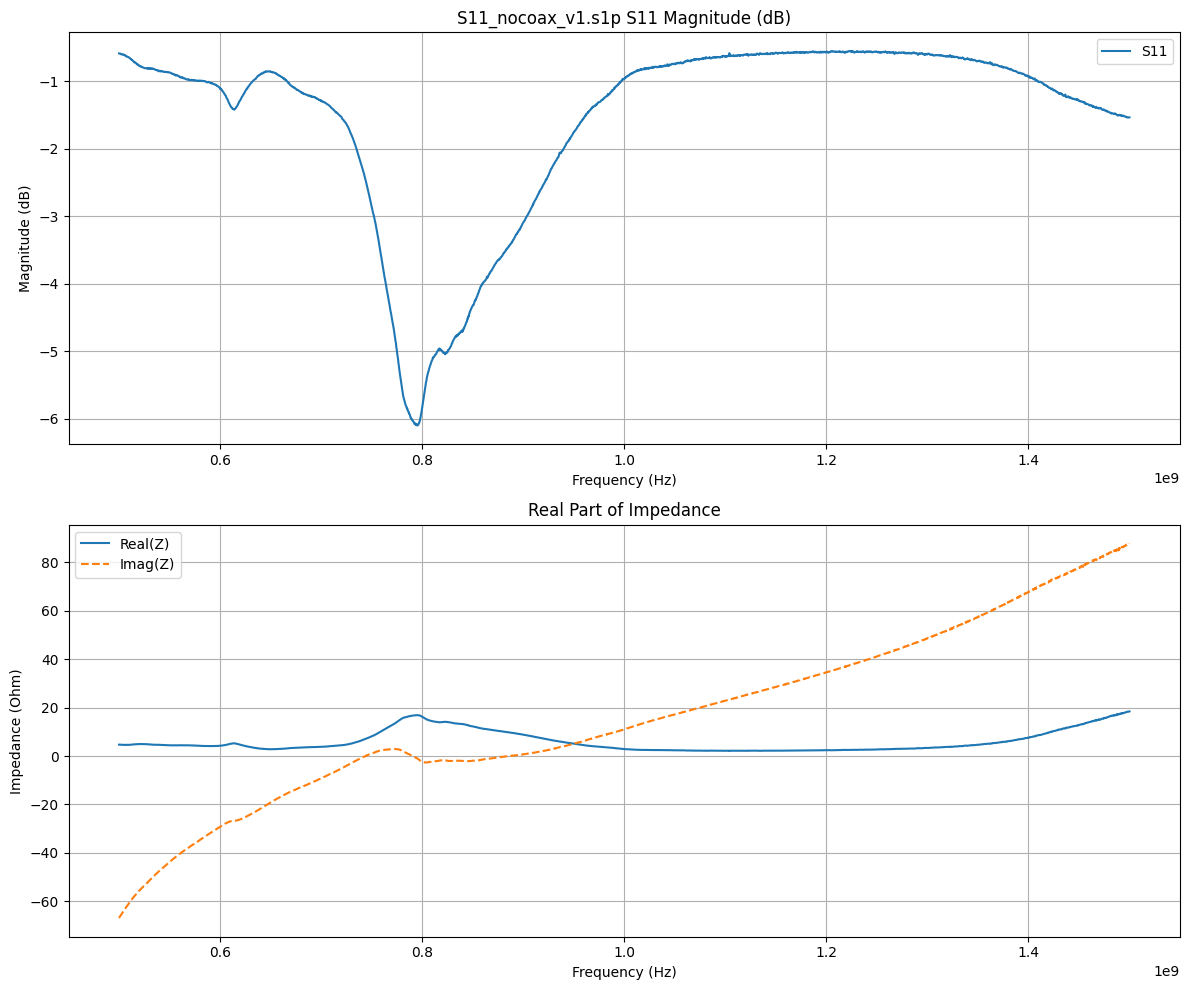

In [ ]:
folder = 'data'
file1 = 'S11_nocoax_v1.s1p'
filepath1 = os.path.join(folder, file1)

ntw1 = rf.Network(filepath1)
freq1 = ntw1.frequency.f
s11_1 = ntw1.s[:, 0, 0]
s11_1_db = 20 * np.log10(np.abs(s11_1))
z1 = ntw1.z[:, 0, 0]

fig, axs = plt.subplots(2, 1, figsize=(12, 10))


axs[0].plot(freq1, s11_1_db, label=f'S11')
axs[0].set_title(f'{file1} S11 Magnitude (dB)')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Magnitude (dB)')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(freq1, np.real(z1), label='Real(Z)')
axs[1].plot(freq2, np.imag(z1), label='Imag(Z)', linestyle='--')
axs[1].set_title('Real Part of Impedance')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Impedance (Ohm)')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()



### Observations
- The return loss is pretty high
- The resonance peak is shifted to 800 MHz
- There is in fact resonance visible (reactance passes through 0)
### Next
- Match the antenna using SimNEC.
- Check the quality of resonance (Q-factor).
- Checks using Scikit-RF

### Matching using SimNEC
- We got to a perfect matching using SimNEC:
	- a T-circuit with (C1: 3.6 pF, L = 4.8 nH, C2: 6 pF)
	- 3.6 pF -> Q-factor tuning (Q ~ X/R)
	- LC -> Match
#### Verifying SimNec Match using Scikit-RF

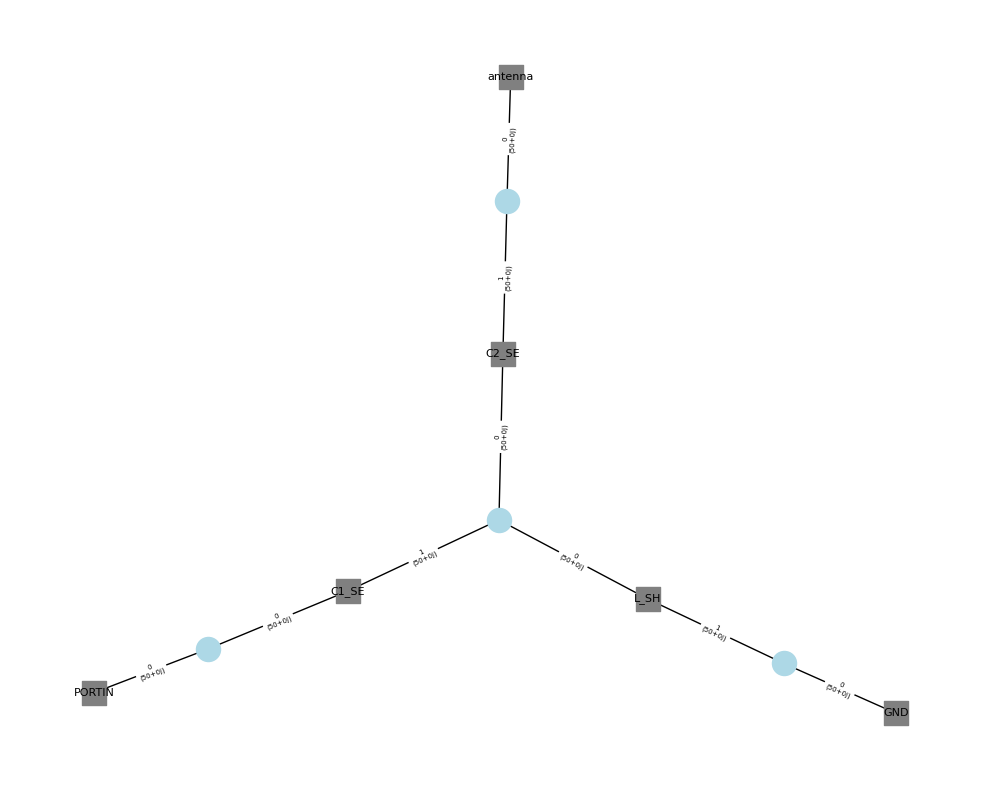

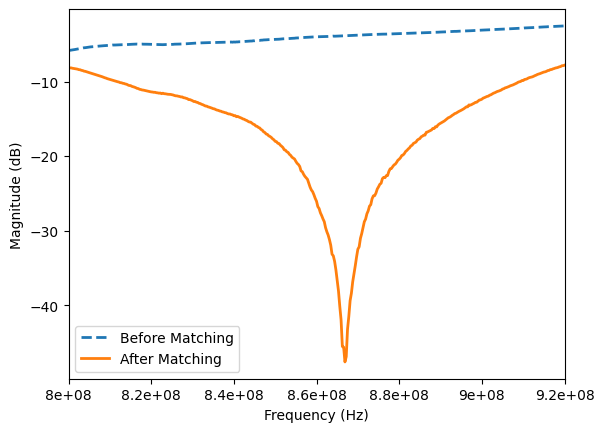

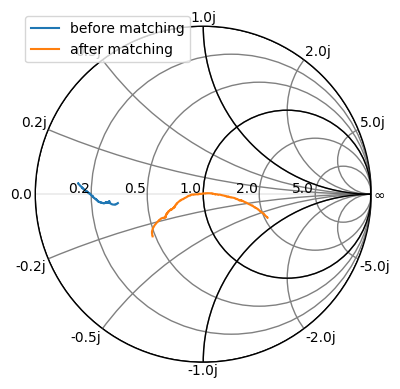

In [16]:
import sys
sys.path.insert(0,'../python_libs')
from rf_matching import build_T_match_network


import numpy as np
import skrf as rf
from skrf.media import DefinedGammaZ0
import matplotlib.pyplot as plt
from scipy.optimize import minimize


Z0 = 50
f_low, f_high = 800e6, 920e6

# Touchstone file with your measured or simulated S11
fname = 'data/S11_nocoax_v1.s1p'
antenna_ntwk = rf.Network(fname)
antenna_ntwk.name = 'antenna'  # give it a name for circuit connections

# **************** CIRCUIT *************
band_ntwk = antenna_ntwk[f'{f_low}-{f_high}']
freq = band_ntwk.frequency  

line = DefinedGammaZ0(frequency=freq, z0=Z0, gamma=0j)  # zero gamma => ideal lumps

C1_val = 3.6e-12
L_val = 4.8e-9
C2_val = 6.0e-12

ckt = build_T_match_network(C1_val, L_val, C2_val, freq, band_ntwk, z0=Z0)

# *************** PLOTS *****************
#! Plot graph
ckt.plot_graph(network_labels=True, network_fontsize=8,
               port_labels=True, port_fontsize=8,
              edge_labels=True, edge_fontsize=5)

plt.show()
#! Plot Matched S11 Before and after Matching
band_ntwk.plot_s_db(m=0, n=0, lw=2, linestyle = '--', label = 'Before Matching')
ckt.network.plot_s_db(m=0, n=0, lw=2, label = 'After Matching')
plt.show()

#! Plot S11 Smith charts before and after matching
band_ntwk.plot_s_smith(label='before matching', draw_labels=True)
ckt.network.plot_s_smith(label='after matching', draw_labels=True)
plt.show()

### Matching using Scikit-RF

Optimization result:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.4748948197735006
       x: [ 3.918e-12  7.735e-09  2.966e-12]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-9.520e-13 -8.924e-10 -9.520e-13]]
    nfev: 34
C1 = 3.918 pF, Optimal L = 7.735 nH,  C2 = 2.966 pF


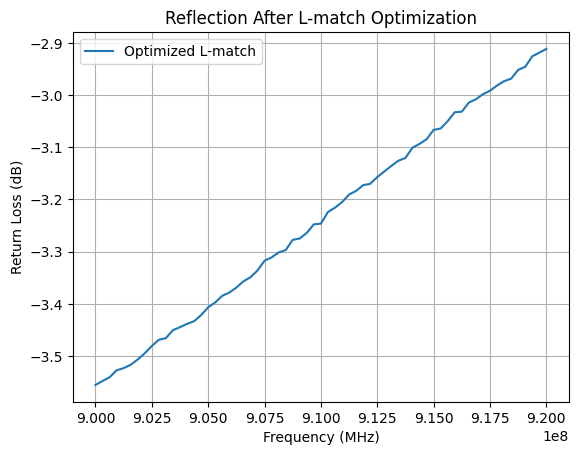

In [4]:
import numpy as np
import skrf as rf
from skrf.media import DefinedGammaZ0
import matplotlib.pyplot as plt
from scipy.optimize import minimize


fname = 'data/S11_nocoax_v1.s1p'
antenna_ntwk = rf.Network(fname)
antenna_ntwk.name = 'antenna'  # give it a name for circuit connections

# Restrict to band
Z0 = 50
f_low, f_high = 900e6, 920e6 #! Matching range
band_ntwk = antenna_ntwk[f'{f_low}-{f_high}']
freq = band_ntwk.frequency  # scikit-rf Frequency object

# Optimization objective
def objective_LC(x, freq, ant_ntwk, z0=50):
    """
    x = [L, C] in Henries, Farads
    Build the circuit, compute reflection across freq, return average reflection^2.
    """
    C1, L, C2 = x
    # penalize invalid or negative values
    if L <= 0 or C1 <= 0 or C2 <= 0:
        return 1e9  # large penalty
    
    # Build the circuit
    net = build_T_match_network(C1, L, C2, freq, ant_ntwk, z0).network
    # Evaluate S11 magnitude (vector over freq)
    s11_mag = net.s11.s_mag
    # Return mean power reflection
    return np.mean(s11_mag**2)

# RUN OPTIMIZATION
L_min, L_max = 0.1e-9, 20e-9    # 0.1 to 20 nH
C_min, C_max = 0.1e-12, 10e-12  # 0.1 to 10 pF
initial_guess = [1e-12, 5e-9, 1e-12]   # L=5nH, C=1pF
bounds = [(C_min, C_max), (L_min, L_max), (C_min, C_max)]

res = minimize(
    objective_LC,
    x0=initial_guess,
    args=(freq, band_ntwk, Z0),
    method='Powell',
    bounds=bounds
)

opt_C1, opt_L, opt_C2 = res.x
print("Optimization result:", res)
print(f"C1 = {opt_C1*1e12:.3f} pF, Optimal L = {opt_L*1e9:.3f} nH,  C2 = {opt_C2*1e12:.3f} pF")

# PLOT
final_match = build_T_match_network(opt_C1, opt_L, opt_C2, freq, band_ntwk, Z0).network
s11_opt = final_match.s11

plt.plot(freq.f_scaled, 20*np.log10(np.abs(s11_opt.s).flatten()), label='Optimized L-match')
plt.xlabel(f"Frequency (MHz)")
plt.ylabel("Return Loss (dB)")
plt.title("Reflection After L-match Optimization")
plt.grid(True)
plt.legend()
plt.show()

#### Conclusion
When performing a match like this using numerical methods and a large amount of degrees of freedom, you might get stuck in local minima.
A better way of optimization would be to limit the search as much as possible in terms of
- Degrees of freedom
- Search domain (C_min, C_max)

Optimization result:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.0011446710725683778
       x: [ 4.776e-09  9.302e-12]
     nit: 10
   direc: [[-5.441e-14  1.214e-21]
           [ 3.450e-11 -1.357e-13]]
    nfev: 435
C1 = 3.600 pF, Optimal L = 4.776 nH, Optimal C2 = 9.302 pF


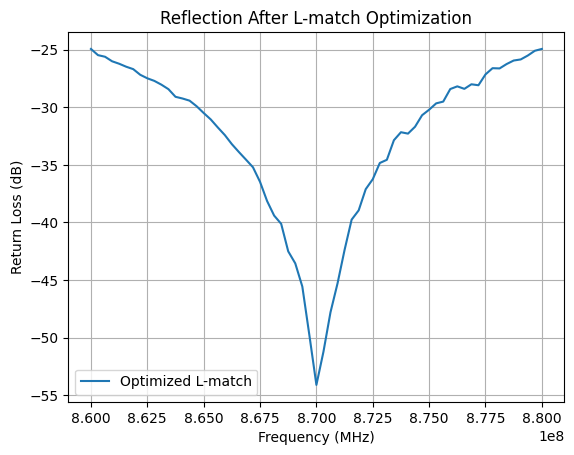

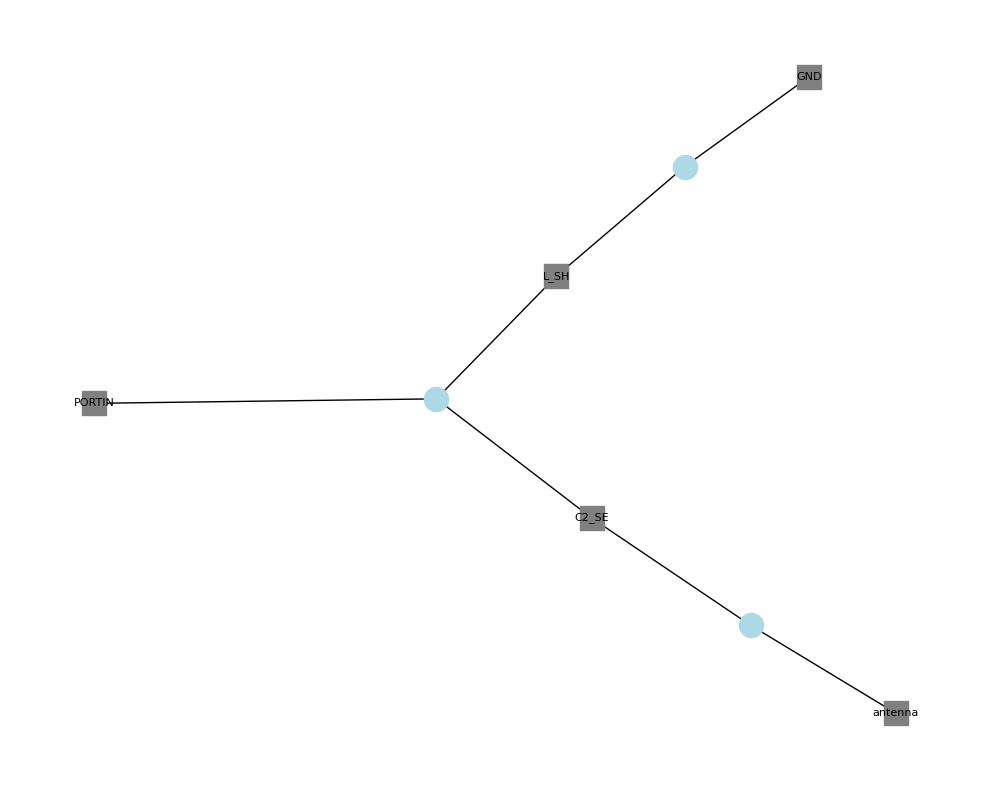

In [5]:
import sys
sys.path.insert(0,'../python_libs')
from rf_matching import build_l_match_network

import numpy as np
import skrf as rf
from skrf.media import DefinedGammaZ0
import matplotlib.pyplot as plt
from scipy.optimize import minimize


fname = 'data/S11_nocoax_v1.s1p'
antenna_ntwk = rf.Network(fname)
antenna_ntwk.name = 'antenna'  # give it a name for circuit connections

# Restrict to band
Z0 = 50
f_low, f_high = 860e6, 880e6 #! Matching range
band_ntwk = antenna_ntwk[f'{f_low}-{f_high}']
freq = band_ntwk.frequency  # scikit-rf Frequency object

# Set initial value for
C1_val = 3.6e-12


# Optimization objective
def objective_LC(x, freq, band_ntwk, z0=50):
    L, C2 = x
    # penalize invalid or negative values
    if L <= 0 or C2 <= 0:
        return 1e9  # large penalty
    
    # Build the circuit
    net = build_l_match_network(L, C2, freq, band_ntwk, z0).network
    # Evaluate S11 magnitude (vector over freq)
    s11_mag = net.s11.s_mag
    # Return mean power reflection
    return np.mean(s11_mag**2)

# RUN OPTIMIZATION
L_min, L_max = 0.1e-9, 20e-9    # 0.1 to 20 nH
C_min, C_max = 0.1e-12, 10e-12  # 0.1 to 10 pF
initial_guess = [5e-9, 1e-12]   # L=5nH, C=1pF
bounds = [(L_min, L_max), (C_min, C_max)]

res = minimize(
    objective_LC,
    x0=initial_guess,
    args=(freq, band_ntwk, Z0),
    method='Powell',
    bounds=bounds
)

opt_L, opt_C2 = res.x
print("Optimization result:", res)
print(f"C1 = {C1_val*1e12:.3f} pF, Optimal L = {opt_L*1e9:.3f} nH, Optimal C2 = {opt_C2*1e12:.3f} pF")

# PLOT
final_match = build_l_match_network(opt_L, opt_C2, freq, band_ntwk, Z0)

s11_opt = final_match.network.s11

plt.plot(freq.f_scaled, 20*np.log10(np.abs(s11_opt.s).flatten()), label='Optimized L-match')
plt.xlabel(f"Frequency (MHz)")
plt.ylabel("Return Loss (dB)")
plt.title("Reflection After L-match Optimization")
plt.grid(True)
plt.legend()
plt.show()

final_match.plot_graph(network_labels=True, network_fontsize=8,
               port_labels=True, port_fontsize=8)
plt.show()

#### Attempted match
We get a perfect match with a T-circuit
- 3.6 pF at the input (done already)
- 4.776 nH with ground (4.7 nH available, by default it's 20 nH to ground)
- 9.3 pF at the antenna (we have 9 and 10 pF)

(1024,), (1024,). freq: (1024,)


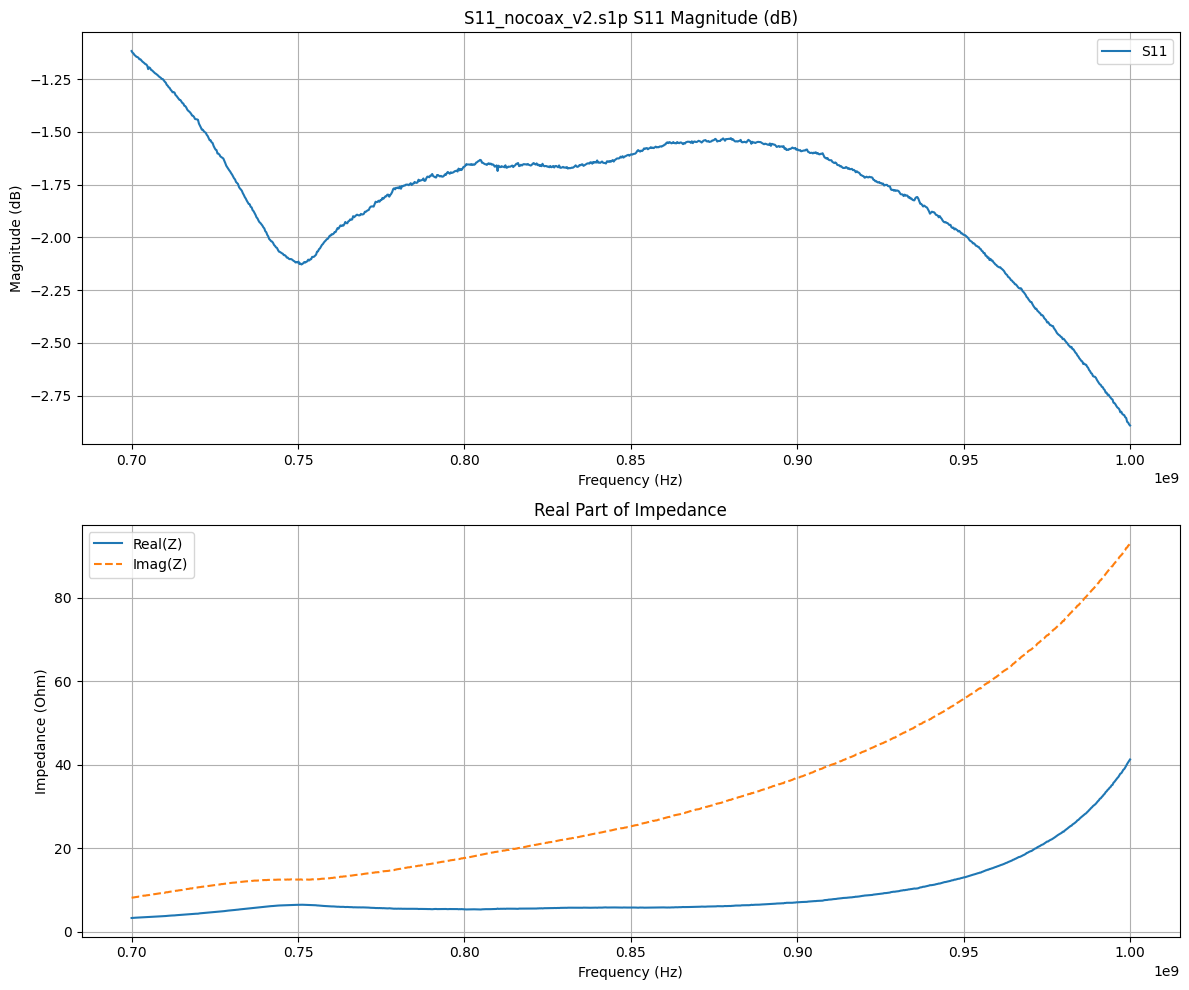

In [ ]:
folder = 'data'
file1 = 'S11_nocoax_v2.s1p'
filepath1 = os.path.join(folder, file1)

ntw1 = rf.Network(filepath1)
freq1 = ntw1.frequency.f
s11_1 = ntw1.s[:, 0, 0]
s11_1_db = 20 * np.log10(np.abs(s11_1))
z1 = ntw1.z[:, 0, 0]

fig, axs = plt.subplots(2, 1, figsize=(12, 10))


axs[0].plot(freq1, s11_1_db, label=f'S11')
axs[0].set_title(f'{file1} S11 Magnitude (dB)')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Magnitude (dB)')
axs[0].grid(True)
axs[0].legend()

print(f"{np.real(z1).shape}, {np.imag(z1).shape}. freq: {freq1.shape}")

axs[1].plot(freq1, np.real(z1), label='Real(Z)')
axs[1].plot(freq1, np.imag(z1), label='Imag(Z)', linestyle='--')
axs[1].set_title('Real Part of Impedance')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Impedance (Ohm)')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

#### Conclusion
It seems like the end result is completely off from the expected one.
- REMEMBER: you can't actually "move" the resonance peak of an antenna by matching it.
- Guess: moving the resonance frequency damps the systems.

#### Next
Let's try to match the antenna with the values we got from SimNec
- L_shunt = 6 pF
- C_series = 6 pF

(2048,), (2048,). freq: (2048,)


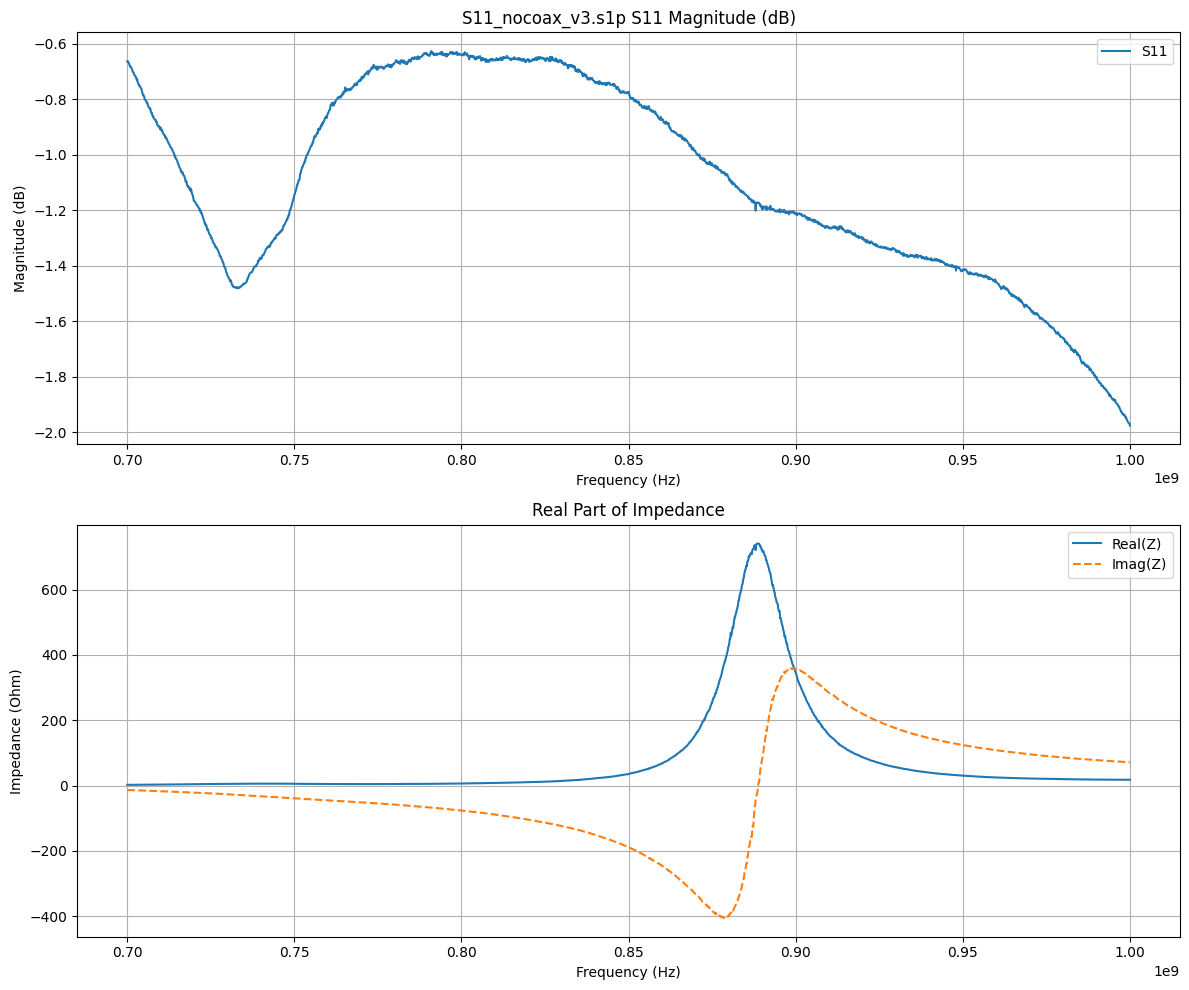

In [18]:
folder = 'data'
file1 = 'S11_nocoax_v3.s1p'
filepath1 = os.path.join(folder, file1)

ntw1 = rf.Network(filepath1)
freq1 = ntw1.frequency.f
s11_1 = ntw1.s[:, 0, 0]
s11_1_db = 20 * np.log10(np.abs(s11_1))
z1 = ntw1.z[:, 0, 0]

fig, axs = plt.subplots(2, 1, figsize=(12, 10))


axs[0].plot(freq1, s11_1_db, label=f'S11')
axs[0].set_title(f'{file1} S11 Magnitude (dB)')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Magnitude (dB)')
axs[0].grid(True)
axs[0].legend()

print(f"{np.real(z1).shape}, {np.imag(z1).shape}. freq: {freq1.shape}")

axs[1].plot(freq1, np.real(z1), label='Real(Z)')
axs[1].plot(freq1, np.imag(z1), label='Imag(Z)', linestyle='--')
axs[1].set_title('Real Part of Impedance')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Impedance (Ohm)')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

#### Conclusion
- It seems like the resonance peak is more present, and is in fact shifted to the right.
	- This resonance is probably the LC-resonance from the circuit itself.
	- Result: high impedance, no return loss
		- Too high to be caused by the antenna
		- Frequency lines up with 1 / (2*pi*sqrt(L*C))
		- First capacitive, then inductive behavior -> parallel LC-resonant behaviour

It seems like the antenna resonance in general is too far away from 868 MHz, the best thing to do would be to cut-off part of the antenna as to increase its resonance frequency.